In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from general_functions import *
from spherical_flux import *
%load_ext autoreload
%autoreload
%autoreload 2

plt.style.use(['seaborn-poster'])

f = h5py.File('batsrus_3d_multi_fluid_95000_10k_3deg.h5','r')

dat_x_values = f['x'][:]
dat_y_values = f['y'][:]
dat_z_values = f['z'][:]

def conversion_sphere_to_cart(r,theta,phi):
    '''converts spherical coords to x,y,z
    INPUTS:
    r: in Rm
    theta: (rad)
    phi: (rad)'''

    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    return x, y, z

def conversion_cart_to_sphere(x,y,z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    return r,theta,phi

dat_r_values, dat_theta_values, dat_phi_values = conversion_cart_to_sphere(dat_x_values, dat_y_values, dat_z_values)

# 500km:

In [2]:
r_sphere_500km = (3390.0+500.0) / 3390.0 #300km above surface
one_hundred_forty_five_km = (145.0) / 3390.0
r = r_sphere_500km
lon = np.arange(-45,91,1)
lat = np.arange(-90,91,1)

phi = -1*(lat-90)*np.pi/180.0
theta = lon*np.pi/180.0

phi_v, theta_v = np.meshgrid(phi, theta)

#Make face centers
phi_f = 0.5*(phi_v[1:,1:]+phi_v[:-1,:-1])
theta_f = 0.5*(theta_v[1:,1:]+theta_v[:-1,:-1])
lat_f = -1*phi_f*180/np.pi+90
lon_f = theta_f*180/np.pi

x = (r*np.cos(theta_f)*np.sin(phi_f)).flatten()
y = (r*np.sin(theta_f)*np.sin(phi_f)).flatten()    
z = (r*np.cos(phi_f)).flatten()
interpolation_spheres_coords_cartesian = np.array([x,y,z])

In [3]:
number_of_points_in_sphere = np.array([])
interpolated_values_array = np.array([])

for i in range(len(interpolation_spheres_coords_cartesian[0])):
    interp_r = np.sqrt(np.sum(interpolation_spheres_coords_cartesian[:,i]**2))
    r_dist = np.abs(dat_r_values - interp_r)
    distance = ((dat_x_values - interpolation_spheres_coords_cartesian[0,i])**2 +
                (dat_y_values - interpolation_spheres_coords_cartesian[1,i])**2 +
                (dat_z_values - interpolation_spheres_coords_cartesian[2,i])**2)
    
    good_points = np.logical_and(distance<=(one_hundred_forty_five_km**2),
                                r_dist<=25.0/3390.0)
    good_x, good_y, good_z, good_distances = dat_x_values[good_points], dat_y_values[good_points], dat_z_values[good_points], distance[good_points]
    number_of_points_in_sphere = np.append(number_of_points_in_sphere, len(good_distances))

    dat_O2_p1_num_dens_values = f['O2_p1_number_density'][:][good_points] #Pulling out values at new indices within interp sphere
    dat_O2_p1_v_x = f['O2_p1_velocity_x'][:][good_points]
    dat_O2_p1_v_y = f['O2_p1_velocity_y'][:][good_points]
    dat_O2_p1_v_z = f['O2_p1_velocity_z'][:][good_points]
    dat_O2_p1_v_tot = np.sqrt(dat_O2_p1_v_x**2 + dat_O2_p1_v_y**2 + dat_O2_p1_v_z**2)

    dat_O_p1_num_dens_values = f['O_p1_number_density'][:][good_points]
    dat_O_p1_v_x = f['O_p1_velocity_x'][:][good_points]
    dat_O_p1_v_y = f['O_p1_velocity_y'][:][good_points]
    dat_O_p1_v_z = f['O_p1_velocity_z'][:][good_points]
    dat_O_p1_v_tot = np.sqrt(dat_O_p1_v_x**2 + dat_O_p1_v_y**2 + dat_O_p1_v_z**2)
    
    mag_field_x = f['magnetic_field_x'][:][good_points]
    mag_field_y = f['magnetic_field_y'][:][good_points]
    mag_field_z = f['magnetic_field_z'][:][good_points]
    mag_field_tot = np.sqrt(mag_field_x**2 + mag_field_y**2 + mag_field_z**2)
    
    interpolation_fields = np.array([dat_O2_p1_num_dens_values, dat_O2_p1_v_x, dat_O2_p1_v_y, dat_O2_p1_v_z, dat_O2_p1_v_tot,
                             dat_O_p1_num_dens_values, dat_O_p1_v_x, dat_O_p1_v_y, dat_O_p1_v_z, dat_O_p1_v_tot, mag_field_tot])

    distances = good_distances #array of distances from center of sphere to points
    weights = 1.0 / (distances) #1/di factor

    for n in range(len(interpolation_fields)):
        numerator = np.sum(weights*interpolation_fields[n])
        denominator = np.sum(weights)
        interpolated_values_array = np.append(interpolated_values_array, (numerator / denominator))

reshaped_interpolated_values_array = np.reshape(interpolated_values_array, (len(interpolation_spheres_coords_cartesian[0]),11))

In [4]:
print np.min(number_of_points_in_sphere)
print np.max(number_of_points_in_sphere)

5.0
440.0


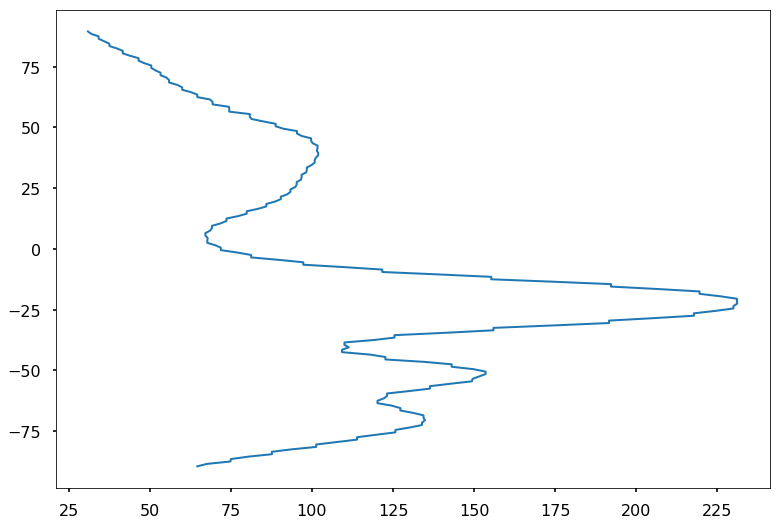

In [8]:
plt.style.use(['seaborn-poster'])
interpolation_sphere_coords_spherical = conversion_cart_to_sphere(interpolation_spheres_coords_cartesian[0], interpolation_spheres_coords_cartesian[1], interpolation_spheres_coords_cartesian[2])
lat_f_array = -1* interpolation_sphere_coords_spherical[2] *180/np.pi+90
lon_f_array = interpolation_sphere_coords_spherical[1] *180/np.pi

rounded_lat_f_array = np.round(lat_f_array, 1)
rounded_lon_f_array = np.round(lon_f_array, 1)

O2_num_dens_data = reshaped_interpolated_values_array[:,0]
O2_vtot_data = reshaped_interpolated_values_array[:,4]

num_dens_0_5 = O2_num_dens_data[np.argwhere(rounded_lon_f_array==0.5)]
lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==0.5)]
plt.plot(num_dens_0_5,lat_values, label='lon 0.5', lw=2)

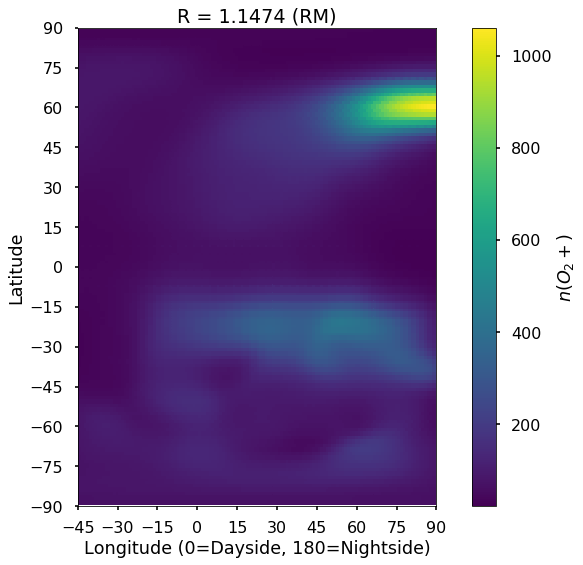

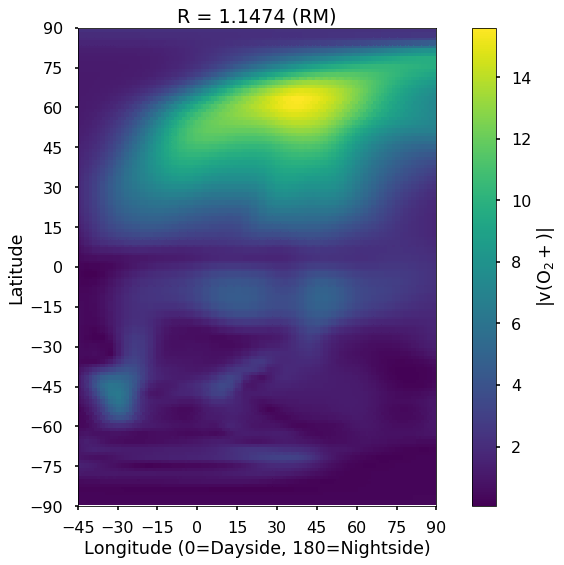

Saving: LR_poletopole_patch_plot_500km_O2_num_dens_145sp_25rad_wide.png
Saving: LR_poletopole_patch_plot_500km_O2_vtot_145sp_25rad_wide.png


In [13]:
xy = lon_f, lat_f
#145km spatial, 25km radial
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.1474, show=True, override_lims=True) 
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.1474, show=True, override_lims=True) 
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.1474, show=False, override_lims=True, fname='LR_poletopole_patch_plot_500km_O2_num_dens_145sp_25rad_wide.png')
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.1474, show=False, override_lims=True, fname='LR_poletopole_patch_plot_500km_O2_vtot_145sp_25rad_wide.png')

# 600km:

In [15]:
r_sphere_600km = (3390.0+600.0) / 3390.0 #300km above surface
one_hundred_forty_five_km = (145.0) / 3390.0
one_hundred_fifty_km = (150.0) / 3390.0
r = r_sphere_600km
lon = np.arange(-45,91,1)
lat = np.arange(-90,91,1)

phi = -1*(lat-90)*np.pi/180.0
theta = lon*np.pi/180.0

phi_v, theta_v = np.meshgrid(phi, theta)

#Make face centers
phi_f = 0.5*(phi_v[1:,1:]+phi_v[:-1,:-1])
theta_f = 0.5*(theta_v[1:,1:]+theta_v[:-1,:-1])
lat_f = -1*phi_f*180/np.pi+90
lon_f = theta_f*180/np.pi

x = (r*np.cos(theta_f)*np.sin(phi_f)).flatten()
y = (r*np.sin(theta_f)*np.sin(phi_f)).flatten()
z = (r*np.cos(phi_f)).flatten()
interpolation_spheres_coords_cartesian = np.array([x,y,z])

In [16]:
number_of_points_in_sphere = np.array([])
interpolated_values_array = np.array([])

for i in range(len(interpolation_spheres_coords_cartesian[0])):
    interp_r = np.sqrt(np.sum(interpolation_spheres_coords_cartesian[:,i]**2))
    r_dist = np.abs(dat_r_values - interp_r)
    distance = ((dat_x_values - interpolation_spheres_coords_cartesian[0,i])**2 +
                (dat_y_values - interpolation_spheres_coords_cartesian[1,i])**2 +
                (dat_z_values - interpolation_spheres_coords_cartesian[2,i])**2)
    
    good_points = np.logical_and(distance<=(one_hundred_fifty_km**2),
                                r_dist<=25.0/3390.0)
    good_x, good_y, good_z, good_distances = dat_x_values[good_points], dat_y_values[good_points], dat_z_values[good_points], distance[good_points]
    number_of_points_in_sphere = np.append(number_of_points_in_sphere, len(good_distances))

    dat_O2_p1_num_dens_values = f['O2_p1_number_density'][:][good_points] #Pulling out values at new indices within interp sphere
    dat_O2_p1_v_x = f['O2_p1_velocity_x'][:][good_points]
    dat_O2_p1_v_y = f['O2_p1_velocity_y'][:][good_points]
    dat_O2_p1_v_z = f['O2_p1_velocity_z'][:][good_points]
    dat_O2_p1_v_tot = np.sqrt(dat_O2_p1_v_x**2 + dat_O2_p1_v_y**2 + dat_O2_p1_v_z**2)

    dat_O_p1_num_dens_values = f['O_p1_number_density'][:][good_points]
    dat_O_p1_v_x = f['O_p1_velocity_x'][:][good_points]
    dat_O_p1_v_y = f['O_p1_velocity_y'][:][good_points]
    dat_O_p1_v_z = f['O_p1_velocity_z'][:][good_points]
    dat_O_p1_v_tot = np.sqrt(dat_O_p1_v_x**2 + dat_O_p1_v_y**2 + dat_O_p1_v_z**2)
    
    mag_field_x = f['magnetic_field_x'][:][good_points]
    mag_field_y = f['magnetic_field_y'][:][good_points]
    mag_field_z = f['magnetic_field_z'][:][good_points]
    mag_field_tot = np.sqrt(mag_field_x**2 + mag_field_y**2 + mag_field_z**2)
    
    interpolation_fields = np.array([dat_O2_p1_num_dens_values, dat_O2_p1_v_x, dat_O2_p1_v_y, dat_O2_p1_v_z, dat_O2_p1_v_tot,
                             dat_O_p1_num_dens_values, dat_O_p1_v_x, dat_O_p1_v_y, dat_O_p1_v_z, dat_O_p1_v_tot, mag_field_tot])

    distances = good_distances #array of distances from center of sphere to points
    weights = 1.0 / (distances) #1/di factor

    for n in range(len(interpolation_fields)):
        numerator = np.sum(weights*interpolation_fields[n])
        denominator = np.sum(weights)
        interpolated_values_array = np.append(interpolated_values_array, (numerator / denominator))

reshaped_interpolated_values_array = np.reshape(interpolated_values_array, (len(interpolation_spheres_coords_cartesian[0]),11))

In [17]:
print np.min(number_of_points_in_sphere)
print np.max(number_of_points_in_sphere)

4.0
354.0


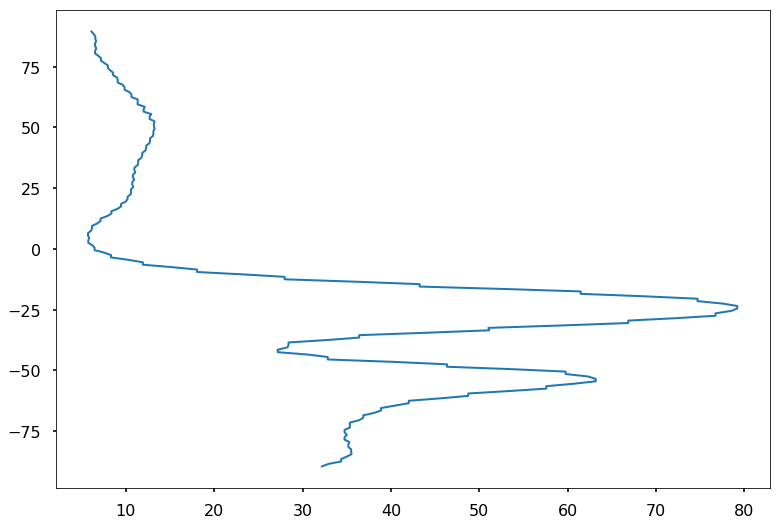

In [21]:
interpolation_sphere_coords_spherical = conversion_cart_to_sphere(interpolation_spheres_coords_cartesian[0], interpolation_spheres_coords_cartesian[1], interpolation_spheres_coords_cartesian[2])
lat_f_array = -1* interpolation_sphere_coords_spherical[2] *180/np.pi+90
lon_f_array = interpolation_sphere_coords_spherical[1] *180/np.pi

rounded_lat_f_array = np.round(lat_f_array, 1)
rounded_lon_f_array = np.round(lon_f_array, 1)

O2_num_dens_data = reshaped_interpolated_values_array[:,0]
O2_vtot_data = reshaped_interpolated_values_array[:,4]

num_dens_0_5 = O2_num_dens_data[np.argwhere(rounded_lon_f_array==0.5)]
lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==0.5)]
plt.plot(num_dens_0_5,lat_values, label='lon 0.5', lw=2)

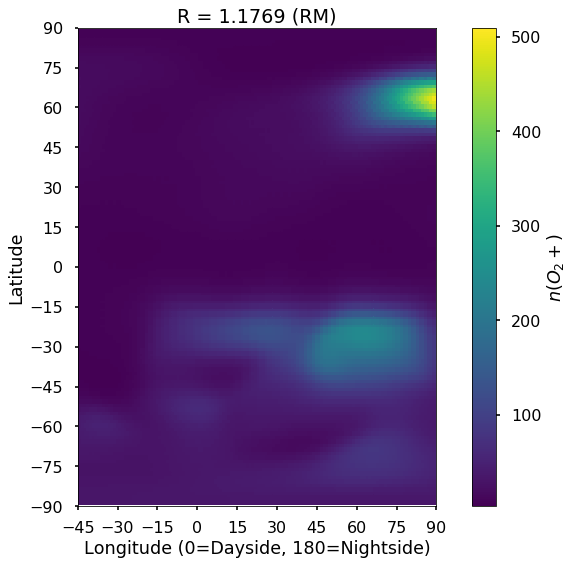

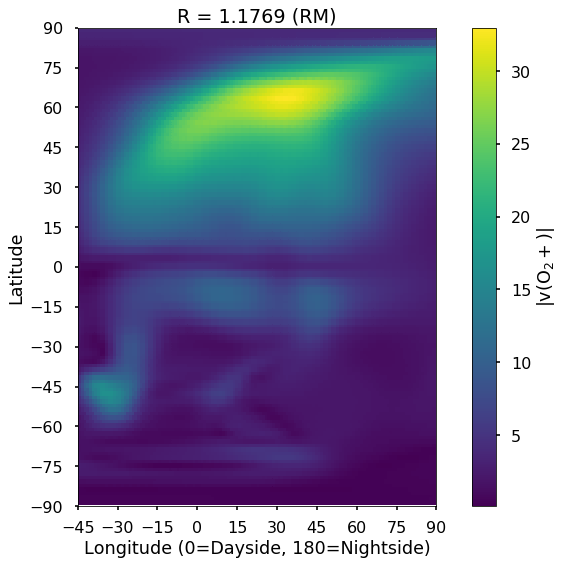

Saving: LR_poletopole_patch_plot_600km_O2_num_dens_150sp_25rad_wide.png
Saving: LR_poletopole_patch_plot_600km_O2_vtot_150sp_25rad_wide.png


In [22]:
xy = lon_f, lat_f
#150km spatial, 25km radial
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.1769, show=True, override_lims=True) 
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.1769, show=True, override_lims=True) 
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.1769, show=False, override_lims=True, fname='LR_poletopole_patch_plot_600km_O2_num_dens_150sp_25rad_wide.png')
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.1769, show=False, override_lims=True, fname='LR_poletopole_patch_plot_600km_O2_vtot_150sp_25rad_wide.png')

# 700km:

In [28]:
r_sphere_700km = (3390.0+700.0) / 3390.0 #300km above surface
one_hundred_fifty_five_km = (155.0) / 3390.0
r = r_sphere_700km
lon = np.arange(-45,136,1)
lat = np.arange(-90,91,1)

phi = -1*(lat-90)*np.pi/180.0
theta = lon*np.pi/180.0

phi_v, theta_v = np.meshgrid(phi, theta)

#Make face centers
phi_f = 0.5*(phi_v[1:,1:]+phi_v[:-1,:-1])
theta_f = 0.5*(theta_v[1:,1:]+theta_v[:-1,:-1])
lat_f = -1*phi_f*180/np.pi+90
lon_f = theta_f*180/np.pi

x = (r*np.cos(theta_f)*np.sin(phi_f)).flatten()
y = (r*np.sin(theta_f)*np.sin(phi_f)).flatten()
z = (r*np.cos(phi_f)).flatten()
interpolation_spheres_coords_cartesian = np.array([x,y,z])

In [29]:
number_of_points_in_sphere = np.array([])
interpolated_values_array = np.array([])

for i in range(len(interpolation_spheres_coords_cartesian[0])):
    interp_r = np.sqrt(np.sum(interpolation_spheres_coords_cartesian[:,i]**2))
    r_dist = np.abs(dat_r_values - interp_r)
    distance = ((dat_x_values - interpolation_spheres_coords_cartesian[0,i])**2 +
                (dat_y_values - interpolation_spheres_coords_cartesian[1,i])**2 +
                (dat_z_values - interpolation_spheres_coords_cartesian[2,i])**2)
    
    good_points = np.logical_and(distance<=(one_hundred_fifty_five_km**2),
                                r_dist<=25.0/3390.0)
    good_x, good_y, good_z, good_distances = dat_x_values[good_points], dat_y_values[good_points], dat_z_values[good_points], distance[good_points]
    number_of_points_in_sphere = np.append(number_of_points_in_sphere, len(good_distances))

    dat_O2_p1_num_dens_values = f['O2_p1_number_density'][:][good_points] #Pulling out values at new indices within interp sphere
    dat_O2_p1_v_x = f['O2_p1_velocity_x'][:][good_points]
    dat_O2_p1_v_y = f['O2_p1_velocity_y'][:][good_points]
    dat_O2_p1_v_z = f['O2_p1_velocity_z'][:][good_points]
    dat_O2_p1_v_tot = np.sqrt(dat_O2_p1_v_x**2 + dat_O2_p1_v_y**2 + dat_O2_p1_v_z**2)

    #dat_O_p1_num_dens_values = f['O_p1_number_density'][:][good_points]
    #dat_O_p1_v_x = f['O_p1_velocity_x'][:][good_points]
    #dat_O_p1_v_y = f['O_p1_velocity_y'][:][good_points]
    #dat_O_p1_v_z = f['O_p1_velocity_z'][:][good_points]
    #dat_O_p1_v_tot = np.sqrt(dat_O_p1_v_x**2 + dat_O_p1_v_y**2 + dat_O_p1_v_z**2)
    
    #mag_field_x = f['magnetic_field_x'][:][good_points]
    #mag_field_y = f['magnetic_field_y'][:][good_points]
    #mag_field_z = f['magnetic_field_z'][:][good_points]
    #mag_field_tot = np.sqrt(mag_field_x**2 + mag_field_y**2 + mag_field_z**2)
    
    interpolation_fields = np.array([dat_O2_p1_num_dens_values, dat_O2_p1_v_x, dat_O2_p1_v_y, dat_O2_p1_v_z, dat_O2_p1_v_tot])
                             #dat_O_p1_num_dens_values, dat_O_p1_v_x, dat_O_p1_v_y, dat_O_p1_v_z, dat_O_p1_v_tot, mag_field_tot])

    distances = good_distances #array of distances from center of sphere to points
    weights = 1.0 / (distances) #1/di factor

    for n in range(len(interpolation_fields)):
        numerator = np.sum(weights*interpolation_fields[n])
        denominator = np.sum(weights)
        interpolated_values_array = np.append(interpolated_values_array, (numerator / denominator))

reshaped_interpolated_values_array = np.reshape(interpolated_values_array, (len(interpolation_spheres_coords_cartesian[0]),5))

In [30]:
print np.min(number_of_points_in_sphere)
print np.max(number_of_points_in_sphere)

2.0
178.0


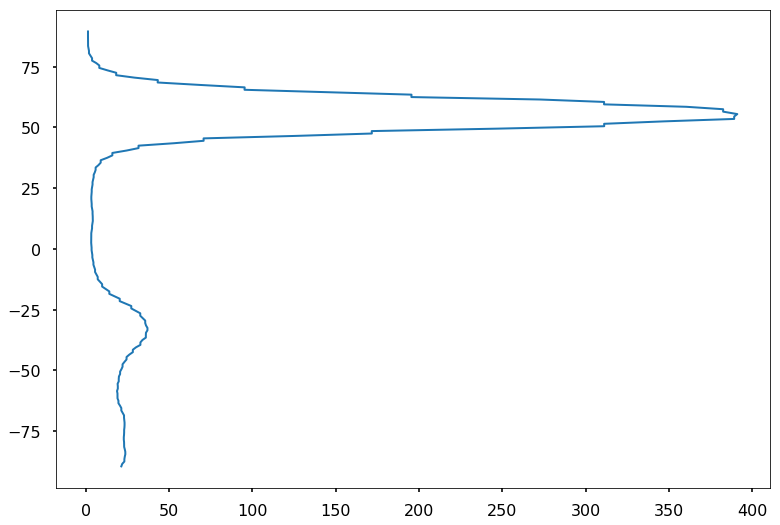

In [38]:
interpolation_sphere_coords_spherical = conversion_cart_to_sphere(interpolation_spheres_coords_cartesian[0], interpolation_spheres_coords_cartesian[1], interpolation_spheres_coords_cartesian[2])
lat_f_array = -1* interpolation_sphere_coords_spherical[2] *180/np.pi+90
lon_f_array = interpolation_sphere_coords_spherical[1] *180/np.pi

rounded_lat_f_array = np.round(lat_f_array, 1)
rounded_lon_f_array = np.round(lon_f_array, 1)

O2_num_dens_data = reshaped_interpolated_values_array[:,0]
O2_vtot_data = reshaped_interpolated_values_array[:,4]

num_dens_0_5 = O2_num_dens_data[np.argwhere(rounded_lon_f_array==134.5)]
lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==134.5)]
plt.plot(num_dens_0_5,lat_values, label='lon 0.5', lw=2)

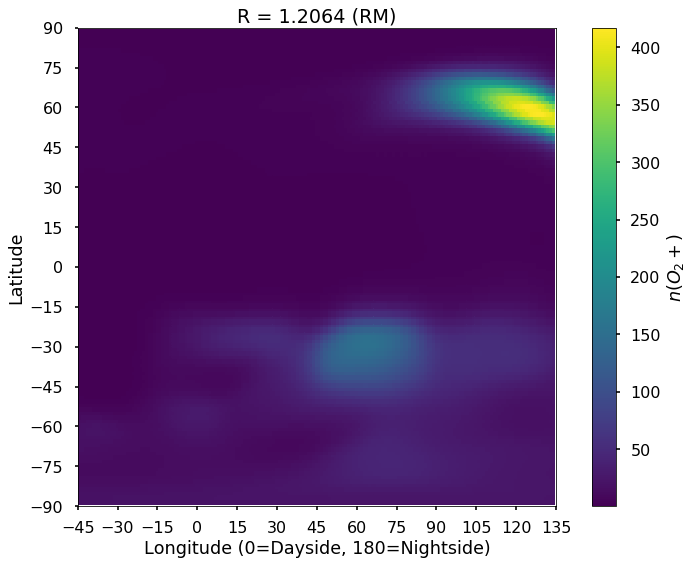

Saving: LR_poletopole_patch_plot_700km_O2_num_dens_155sp_25rad_wide.png


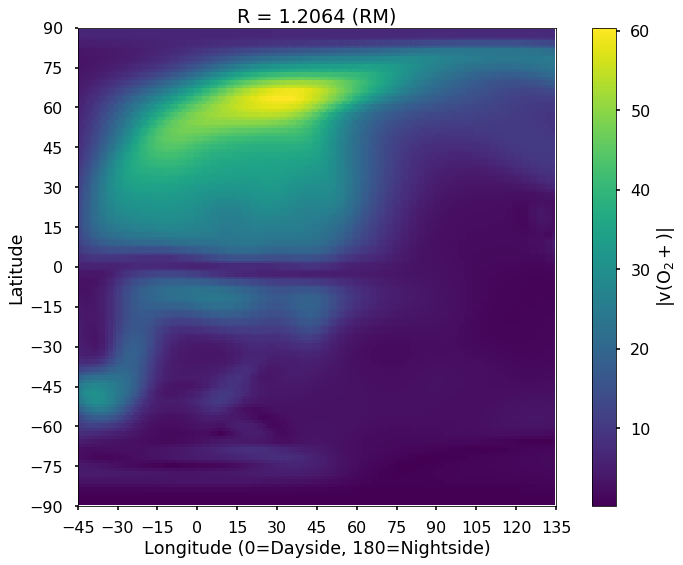

Saving: LR_poletopole_patch_plot_700km_O2_vtot_155sp_25rad_wide.png


In [39]:
xy = lon_f, lat_f
#155km spatial, 25km radial
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2064, show=True, override_lims=True) 
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2064, show=False, override_lims=True, fname='LR_poletopole_patch_plot_700km_O2_num_dens_155sp_25rad_wide.png')
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2064, show=True, override_lims=True) 
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2064, show=False, override_lims=True, fname='LR_poletopole_patch_plot_700km_O2_vtot_155sp_25rad_wide.png')

# 800km:

In [52]:
r_sphere_800km = (3390.0+800.0) / 3390.0 #300km above surface
one_hundred_sixty_km = (160.0) / 3390.0
r = r_sphere_800km
lon = np.arange(-45,136,1)
lat = np.arange(-90,91,1)

phi = -1*(lat-90)*np.pi/180.0
theta = lon*np.pi/180.0

phi_v, theta_v = np.meshgrid(phi, theta)

#Make face centers
phi_f = 0.5*(phi_v[1:,1:]+phi_v[:-1,:-1])
theta_f = 0.5*(theta_v[1:,1:]+theta_v[:-1,:-1])
lat_f = -1*phi_f*180/np.pi+90
lon_f = theta_f*180/np.pi

x = (r*np.cos(theta_f)*np.sin(phi_f)).flatten()
y = (r*np.sin(theta_f)*np.sin(phi_f)).flatten()
z = (r*np.cos(phi_f)).flatten()
interpolation_spheres_coords_cartesian = np.array([x,y,z])

In [53]:
number_of_points_in_sphere = np.array([])
interpolated_values_array = np.array([])

for i in range(len(interpolation_spheres_coords_cartesian[0])):
    interp_r = np.sqrt(np.sum(interpolation_spheres_coords_cartesian[:,i]**2))
    r_dist = np.abs(dat_r_values - interp_r)
    distance = ((dat_x_values - interpolation_spheres_coords_cartesian[0,i])**2 +
                (dat_y_values - interpolation_spheres_coords_cartesian[1,i])**2 +
                (dat_z_values - interpolation_spheres_coords_cartesian[2,i])**2)
    
    good_points = np.logical_and(distance<=(one_hundred_sixty_km**2),
                                r_dist<=25.0/3390.0)
    good_x, good_y, good_z, good_distances = dat_x_values[good_points], dat_y_values[good_points], dat_z_values[good_points], distance[good_points]
    number_of_points_in_sphere = np.append(number_of_points_in_sphere, len(good_distances))

    dat_O2_p1_num_dens_values = f['O2_p1_number_density'][:][good_points] #Pulling out values at new indices within interp sphere
    dat_O2_p1_v_x = f['O2_p1_velocity_x'][:][good_points]
    dat_O2_p1_v_y = f['O2_p1_velocity_y'][:][good_points]
    dat_O2_p1_v_z = f['O2_p1_velocity_z'][:][good_points]
    dat_O2_p1_v_tot = np.sqrt(dat_O2_p1_v_x**2 + dat_O2_p1_v_y**2 + dat_O2_p1_v_z**2)

    #dat_O_p1_num_dens_values = f['O_p1_number_density'][:][good_points]
    #dat_O_p1_v_x = f['O_p1_velocity_x'][:][good_points]
    #dat_O_p1_v_y = f['O_p1_velocity_y'][:][good_points]
    #dat_O_p1_v_z = f['O_p1_velocity_z'][:][good_points]
    #dat_O_p1_v_tot = np.sqrt(dat_O_p1_v_x**2 + dat_O_p1_v_y**2 + dat_O_p1_v_z**2)
    
    #mag_field_x = f['magnetic_field_x'][:][good_points]
    #mag_field_y = f['magnetic_field_y'][:][good_points]
    #mag_field_z = f['magnetic_field_z'][:][good_points]
    #mag_field_tot = np.sqrt(mag_field_x**2 + mag_field_y**2 + mag_field_z**2)
    
    interpolation_fields = np.array([dat_O2_p1_num_dens_values, dat_O2_p1_v_x, dat_O2_p1_v_y, dat_O2_p1_v_z, dat_O2_p1_v_tot])
                             #dat_O_p1_num_dens_values, dat_O_p1_v_x, dat_O_p1_v_y, dat_O_p1_v_z, dat_O_p1_v_tot, mag_field_tot])

    distances = good_distances #array of distances from center of sphere to points
    weights = 1.0 / (distances) #1/di factor

    for n in range(len(interpolation_fields)):
        numerator = np.sum(weights*interpolation_fields[n])
        denominator = np.sum(weights)
        interpolated_values_array = np.append(interpolated_values_array, (numerator / denominator))

reshaped_interpolated_values_array = np.reshape(interpolated_values_array, (len(interpolation_spheres_coords_cartesian[0]),5))

In [54]:
print np.min(number_of_points_in_sphere)
print np.max(number_of_points_in_sphere)

2.0
178.0


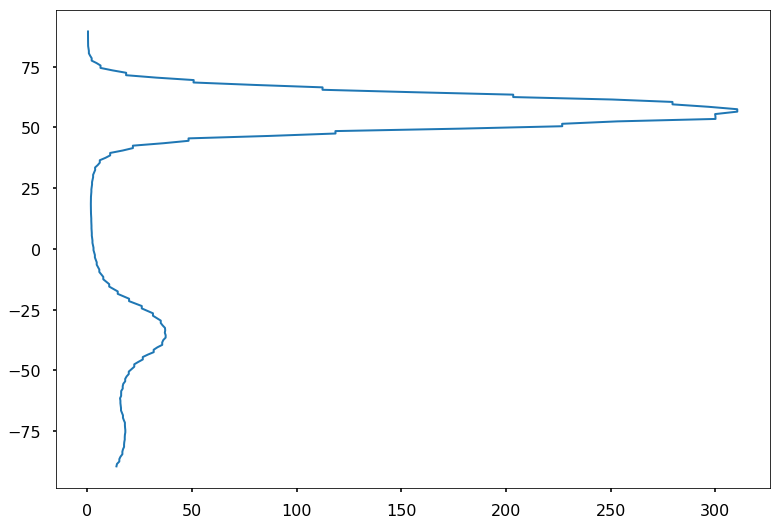

In [58]:
interpolation_sphere_coords_spherical = conversion_cart_to_sphere(interpolation_spheres_coords_cartesian[0], interpolation_spheres_coords_cartesian[1], interpolation_spheres_coords_cartesian[2])
lat_f_array = -1* interpolation_sphere_coords_spherical[2] *180/np.pi+90
lon_f_array = interpolation_sphere_coords_spherical[1] *180/np.pi

rounded_lat_f_array = np.round(lat_f_array, 1)
rounded_lon_f_array = np.round(lon_f_array, 1)

O2_num_dens_data = reshaped_interpolated_values_array[:,0]
O2_vtot_data = reshaped_interpolated_values_array[:,4]

num_dens_lon = O2_num_dens_data[np.argwhere(rounded_lon_f_array==134.5)]
lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==134.5)]
plt.plot(num_dens_lon,lat_values, lw=2)

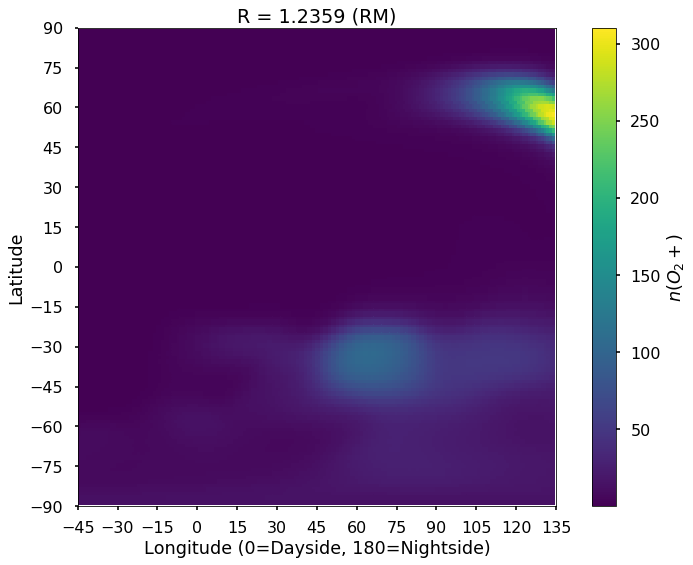

Saving: LR_poletopole_patch_plot_800km_O2_num_dens_160sp_25rad_wide.png


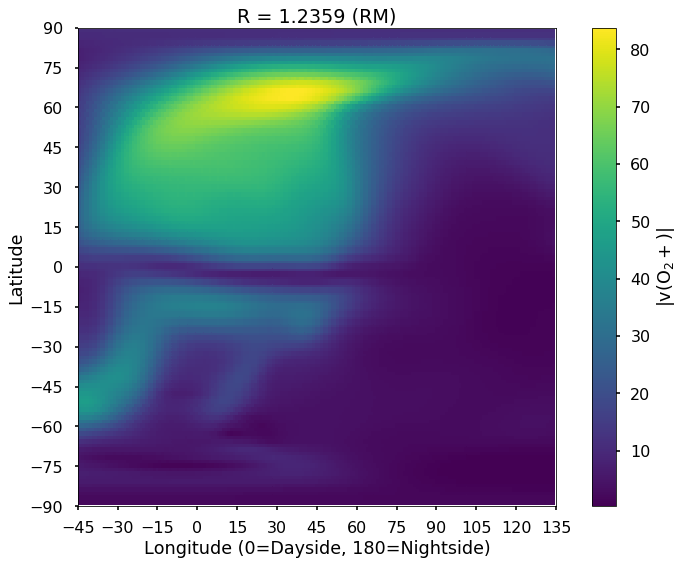

Saving: LR_poletopole_patch_plot_800km_O2_vtot_160sp_25rad_wide.png


In [60]:
xy = lon_f, lat_f
#160km spatial, 25km radial
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2359, show=True, override_lims=True) 
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2359, show=False, override_lims=True, fname='LR_poletopole_patch_plot_800km_O2_num_dens_160sp_25rad_wide.png')
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2359, show=True, override_lims=True) 
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2359, show=False, override_lims=True, fname='LR_poletopole_patch_plot_800km_O2_vtot_160sp_25rad_wide.png')

# 900km:

In [61]:
r_sphere_900km = (3390.0+900.0) / 3390.0 #300km above surface
one_hundred_sixty_km = (160.0) / 3390.0
r = r_sphere_900km
lon = np.arange(-45,136,1)
lat = np.arange(-90,91,1)

phi = -1*(lat-90)*np.pi/180.0
theta = lon*np.pi/180.0

phi_v, theta_v = np.meshgrid(phi, theta)

#Make face centers
phi_f = 0.5*(phi_v[1:,1:]+phi_v[:-1,:-1])
theta_f = 0.5*(theta_v[1:,1:]+theta_v[:-1,:-1])
lat_f = -1*phi_f*180/np.pi+90
lon_f = theta_f*180/np.pi

x = (r*np.cos(theta_f)*np.sin(phi_f)).flatten()
y = (r*np.sin(theta_f)*np.sin(phi_f)).flatten()
z = (r*np.cos(phi_f)).flatten()
interpolation_spheres_coords_cartesian = np.array([x,y,z])

In [68]:
number_of_points_in_sphere = np.array([])
interpolated_values_array = np.array([])

for i in range(len(interpolation_spheres_coords_cartesian[0])):
    interp_r = np.sqrt(np.sum(interpolation_spheres_coords_cartesian[:,i]**2))
    r_dist = np.abs(dat_r_values - interp_r)
    distance = ((dat_x_values - interpolation_spheres_coords_cartesian[0,i])**2 +
                (dat_y_values - interpolation_spheres_coords_cartesian[1,i])**2 +
                (dat_z_values - interpolation_spheres_coords_cartesian[2,i])**2)
    
    good_points = np.logical_and(distance<=(one_hundred_sixty_km**2),
                                r_dist<=25.0/3390.0)
    good_x, good_y, good_z, good_distances = dat_x_values[good_points], dat_y_values[good_points], dat_z_values[good_points], distance[good_points]
    number_of_points_in_sphere = np.append(number_of_points_in_sphere, len(good_distances))

    dat_O2_p1_num_dens_values = f['O2_p1_number_density'][:][good_points] #Pulling out values at new indices within interp sphere
    dat_O2_p1_v_x = f['O2_p1_velocity_x'][:][good_points]
    dat_O2_p1_v_y = f['O2_p1_velocity_y'][:][good_points]
    dat_O2_p1_v_z = f['O2_p1_velocity_z'][:][good_points]
    dat_O2_p1_v_tot = np.sqrt(dat_O2_p1_v_x**2 + dat_O2_p1_v_y**2 + dat_O2_p1_v_z**2)

    #dat_O_p1_num_dens_values = f['O_p1_number_density'][:][good_points]
    #dat_O_p1_v_x = f['O_p1_velocity_x'][:][good_points]
    #dat_O_p1_v_y = f['O_p1_velocity_y'][:][good_points]
    #dat_O_p1_v_z = f['O_p1_velocity_z'][:][good_points]
    #dat_O_p1_v_tot = np.sqrt(dat_O_p1_v_x**2 + dat_O_p1_v_y**2 + dat_O_p1_v_z**2)
    
    #mag_field_x = f['magnetic_field_x'][:][good_points]
    #mag_field_y = f['magnetic_field_y'][:][good_points]
    #mag_field_z = f['magnetic_field_z'][:][good_points]
    #mag_field_tot = np.sqrt(mag_field_x**2 + mag_field_y**2 + mag_field_z**2)
    
    interpolation_fields = np.array([dat_O2_p1_num_dens_values, dat_O2_p1_v_x, dat_O2_p1_v_y, dat_O2_p1_v_z, dat_O2_p1_v_tot])
                             #dat_O_p1_num_dens_values, dat_O_p1_v_x, dat_O_p1_v_y, dat_O_p1_v_z, dat_O_p1_v_tot, mag_field_tot])

    distances = good_distances #array of distances from center of sphere to points
    weights = 1.0 / (distances) #1/di factor

    for n in range(len(interpolation_fields)):
        numerator = np.sum(weights*interpolation_fields[n])
        denominator = np.sum(weights)
        interpolated_values_array = np.append(interpolated_values_array, (numerator / denominator))

reshaped_interpolated_values_array = np.reshape(interpolated_values_array, (len(interpolation_spheres_coords_cartesian[0]),5))

In [69]:
print np.min(number_of_points_in_sphere)
print np.max(number_of_points_in_sphere)

3.0
261.0


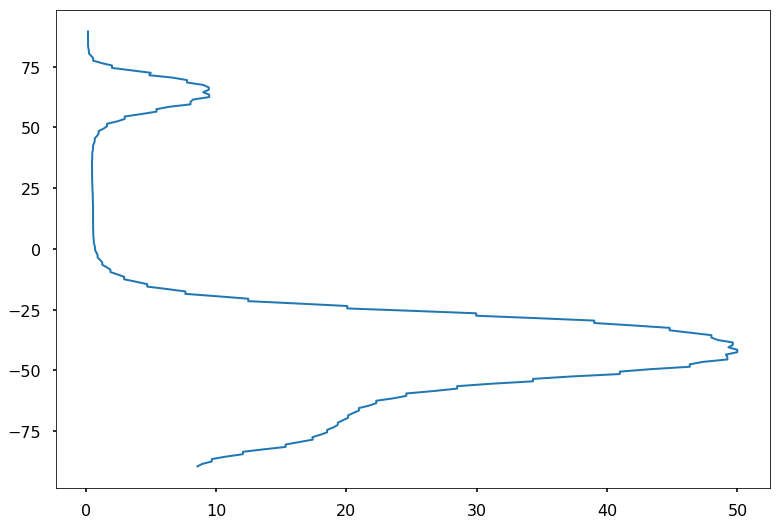

In [70]:
interpolation_sphere_coords_spherical = conversion_cart_to_sphere(interpolation_spheres_coords_cartesian[0], interpolation_spheres_coords_cartesian[1], interpolation_spheres_coords_cartesian[2])
lat_f_array = -1* interpolation_sphere_coords_spherical[2] *180/np.pi+90
lon_f_array = interpolation_sphere_coords_spherical[1] *180/np.pi

rounded_lat_f_array = np.round(lat_f_array, 1)
rounded_lon_f_array = np.round(lon_f_array, 1)

O2_num_dens_data = reshaped_interpolated_values_array[:,0]
O2_vtot_data = reshaped_interpolated_values_array[:,4]

num_dens_lon_values = O2_num_dens_data[np.argwhere(rounded_lon_f_array==89.5)]
lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==89.5)]
plt.plot(num_dens_lon_values,lat_values, lw=2)

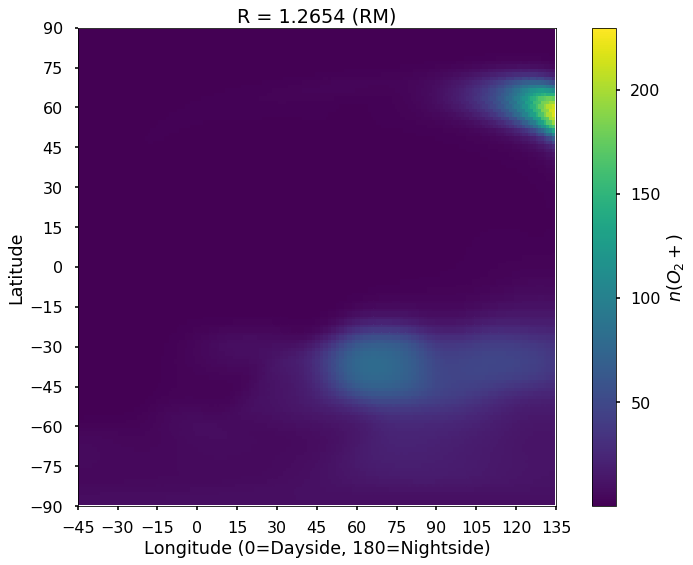

Saving: LR_poletopole_patch_plot_900km_O2_num_dens_160sp_25rad_wide.png


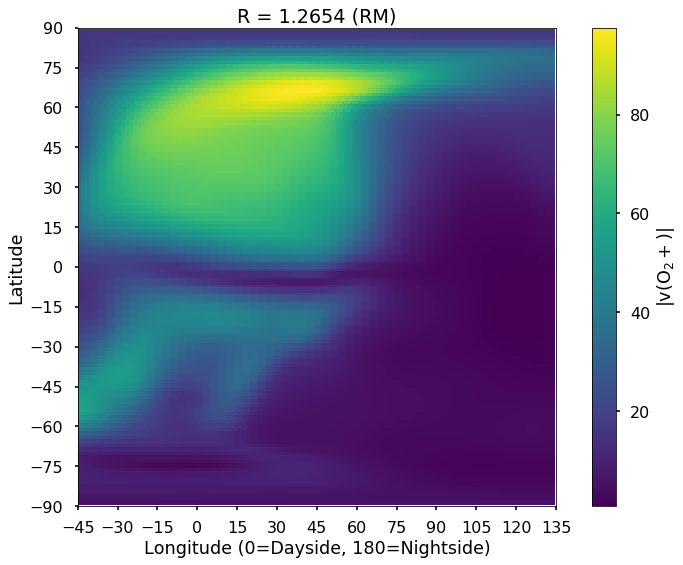

Saving: LR_poletopole_patch_plot_900km_O2_vtot_160sp_25rad_wide.png


In [67]:
xy = lon_f, lat_f
#160km spatial, 25km radial
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2654, show=True, override_lims=True) 
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2654, show=False, override_lims=True, fname='LR_poletopole_patch_plot_900km_O2_num_dens_160sp_25rad_wide.png')
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2654, show=True, override_lims=True) 
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2654, show=False, override_lims=True, fname='LR_poletopole_patch_plot_900km_O2_vtot_160sp_25rad_wide.png')

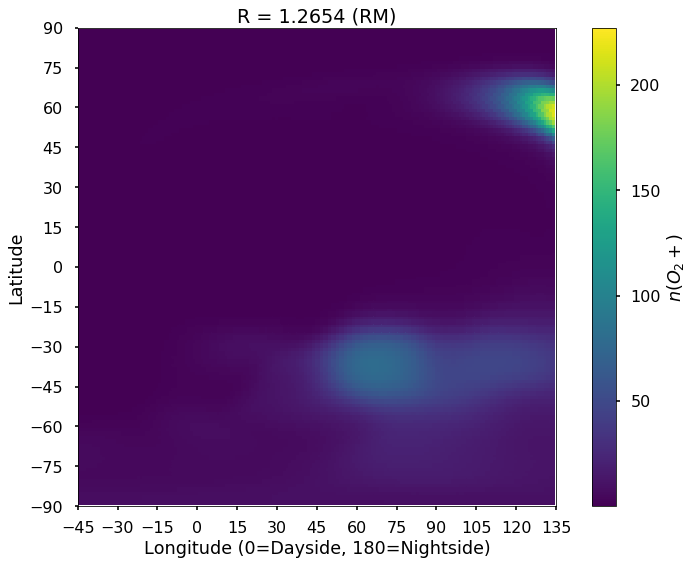

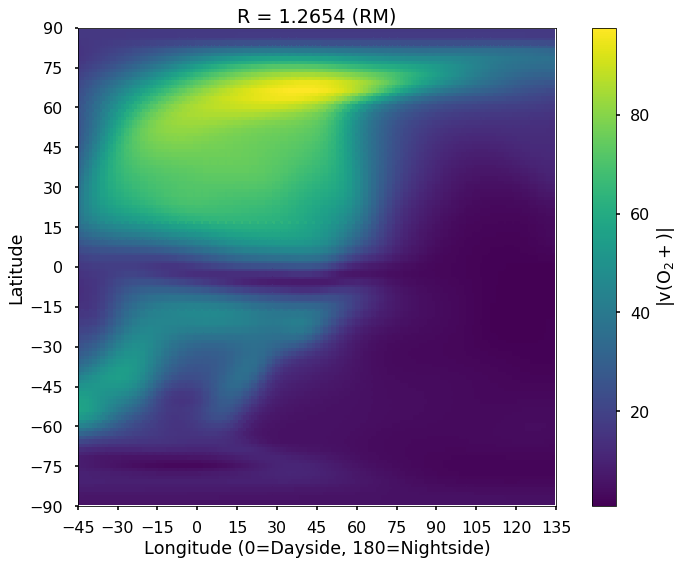

In [71]:
xy = lon_f, lat_f
#160km spatial, 25km radial
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2654, show=True, override_lims=True) 
#create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2654, show=False, override_lims=True, fname='LR_poletopole_patch_plot_900km_O2_num_dens_160sp_25rad_wide.png')
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2654, show=True, override_lims=True) 
#create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2654, show=False, override_lims=True, fname='LR_poletopole_patch_plot_900km_O2_vtot_160sp_25rad_wide.png')

# 1000km:

In [84]:
r_sphere_1000km = (3390.0+1000.0) / 3390.0 
one_hundred_sixty_five_km = (165.0) / 3390.0
r = r_sphere_1000km
lon = np.arange(-90,270,1)
lat = np.arange(-90,91,1)

phi = -1*(lat-90)*np.pi/180.0
theta = lon*np.pi/180.0

phi_v, theta_v = np.meshgrid(phi, theta)

#Make face centers
phi_f = 0.5*(phi_v[1:,1:]+phi_v[:-1,:-1])
theta_f = 0.5*(theta_v[1:,1:]+theta_v[:-1,:-1])
lat_f = -1*phi_f*180/np.pi+90
lon_f = theta_f*180/np.pi

x = (r*np.cos(theta_f)*np.sin(phi_f)).flatten()
y = (r*np.sin(theta_f)*np.sin(phi_f)).flatten()
z = (r*np.cos(phi_f)).flatten()
interpolation_spheres_coords_cartesian = np.array([x,y,z])

In [85]:
number_of_points_in_sphere = np.array([])
interpolated_values_array = np.array([])

for i in range(len(interpolation_spheres_coords_cartesian[0])):
    interp_r = np.sqrt(np.sum(interpolation_spheres_coords_cartesian[:,i]**2))
    r_dist = np.abs(dat_r_values - interp_r)
    distance = ((dat_x_values - interpolation_spheres_coords_cartesian[0,i])**2 +
                (dat_y_values - interpolation_spheres_coords_cartesian[1,i])**2 +
                (dat_z_values - interpolation_spheres_coords_cartesian[2,i])**2)
    
    good_points = np.logical_and(distance<=(one_hundred_sixty_five_km**2),
                                r_dist<=25.0/3390.0)
    good_x, good_y, good_z, good_distances = dat_x_values[good_points], dat_y_values[good_points], dat_z_values[good_points], distance[good_points]
    number_of_points_in_sphere = np.append(number_of_points_in_sphere, len(good_distances))

    dat_O2_p1_num_dens_values = f['O2_p1_number_density'][:][good_points] #Pulling out values at new indices within interp sphere
    dat_O2_p1_v_x = f['O2_p1_velocity_x'][:][good_points]
    dat_O2_p1_v_y = f['O2_p1_velocity_y'][:][good_points]
    dat_O2_p1_v_z = f['O2_p1_velocity_z'][:][good_points]
    dat_O2_p1_v_tot = np.sqrt(dat_O2_p1_v_x**2 + dat_O2_p1_v_y**2 + dat_O2_p1_v_z**2)

    #dat_O_p1_num_dens_values = f['O_p1_number_density'][:][good_points]
    #dat_O_p1_v_x = f['O_p1_velocity_x'][:][good_points]
    #dat_O_p1_v_y = f['O_p1_velocity_y'][:][good_points]
    #dat_O_p1_v_z = f['O_p1_velocity_z'][:][good_points]
    #dat_O_p1_v_tot = np.sqrt(dat_O_p1_v_x**2 + dat_O_p1_v_y**2 + dat_O_p1_v_z**2)
    
    #mag_field_x = f['magnetic_field_x'][:][good_points]
    #mag_field_y = f['magnetic_field_y'][:][good_points]
    #mag_field_z = f['magnetic_field_z'][:][good_points]
    #mag_field_tot = np.sqrt(mag_field_x**2 + mag_field_y**2 + mag_field_z**2)
    
    interpolation_fields = np.array([dat_O2_p1_num_dens_values, dat_O2_p1_v_x, dat_O2_p1_v_y, dat_O2_p1_v_z, dat_O2_p1_v_tot])
                             #dat_O_p1_num_dens_values, dat_O_p1_v_x, dat_O_p1_v_y, dat_O_p1_v_z, dat_O_p1_v_tot, mag_field_tot])

    distances = good_distances #array of distances from center of sphere to points
    weights = 1.0 / (distances) #1/di factor

    for n in range(len(interpolation_fields)):
        numerator = np.sum(weights*interpolation_fields[n])
        denominator = np.sum(weights)
        interpolated_values_array = np.append(interpolated_values_array, (numerator / denominator))

reshaped_interpolated_values_array = np.reshape(interpolated_values_array, (len(interpolation_spheres_coords_cartesian[0]),5))

In [86]:
print np.min(number_of_points_in_sphere)
print np.max(number_of_points_in_sphere)

2.0
176.0


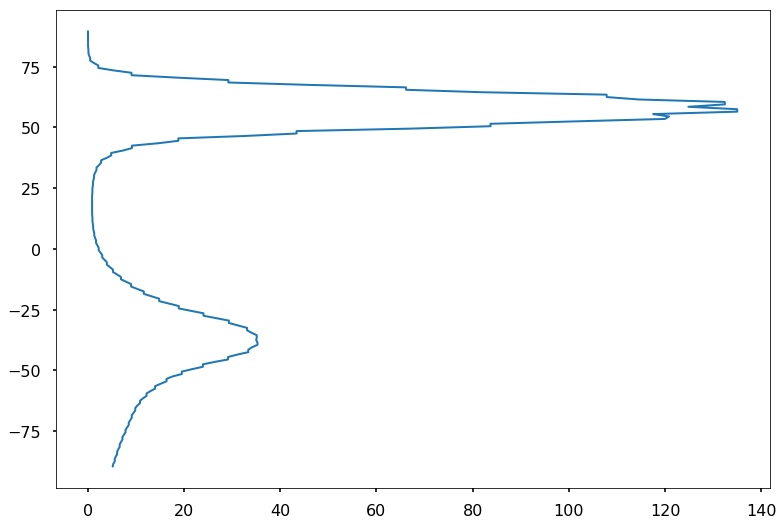

In [87]:
interpolation_sphere_coords_spherical = conversion_cart_to_sphere(interpolation_spheres_coords_cartesian[0], interpolation_spheres_coords_cartesian[1], interpolation_spheres_coords_cartesian[2])
lat_f_array = -1* interpolation_sphere_coords_spherical[2] *180/np.pi+90
lon_f_array = interpolation_sphere_coords_spherical[1] *180/np.pi

rounded_lat_f_array = np.round(lat_f_array, 1)
rounded_lon_f_array = np.round(lon_f_array, 1)

O2_num_dens_data = reshaped_interpolated_values_array[:,0]
O2_vtot_data = reshaped_interpolated_values_array[:,4]

num_dens_lon_values = O2_num_dens_data[np.argwhere(rounded_lon_f_array==134.5)]
lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==134.5)]
plt.plot(num_dens_lon_values,lat_values, lw=2)

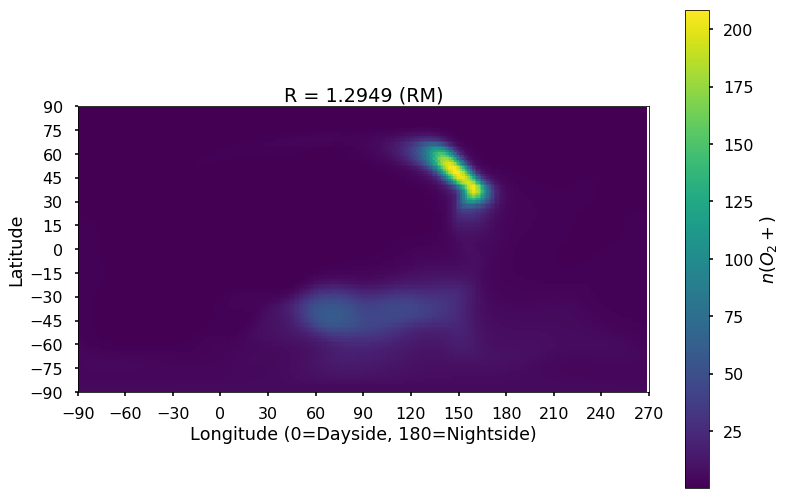

Saving: LR_full_map_patch_plot_1000km_O2_num_dens_165sp_25rad_wide.png


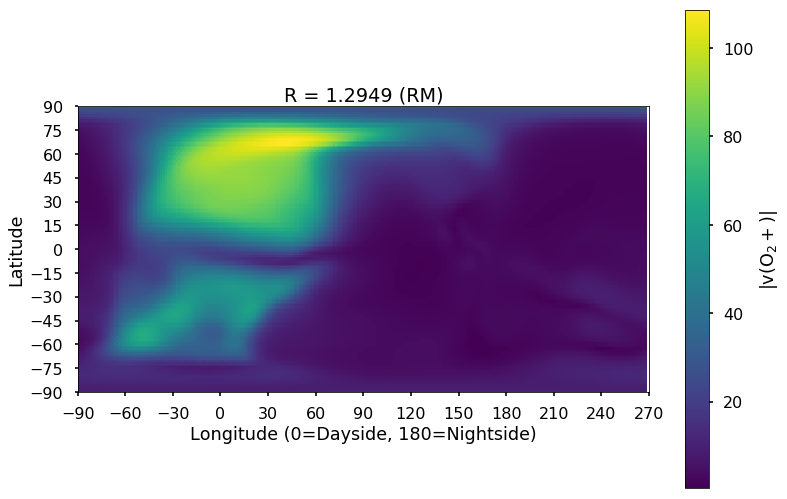

Saving: LR_full_map_patch_plot_1000km_O2_vtot_165sp_25rad_wide.png


In [91]:
xy = lon_f, lat_f
#165km spatial, 25km radial 
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2949, show=True, override_lims=True) 
create_plot('O2_p1_number_density',xy, O2_num_dens_data, r=1.2949, show=False, override_lims=True, fname='LR_full_map_patch_plot_1000km_O2_num_dens_165sp_25rad_wide.png')
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2949, show=True, override_lims=True) 
create_plot('O2_p1_velocity_total',xy, O2_vtot_data, r=1.2949, show=False, override_lims=True, fname='LR_full_map_patch_plot_1000km_O2_vtot_165sp_25rad_wide.png')